In [1]:
import json
import math
import os
import re
import shutil
from collections import defaultdict
from operator import itemgetter
from pathlib import Path
from pprint import pprint

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fastcore.utils import parallel
from sklearn.model_selection import train_test_split
import seaborn as sns

plt.rcParams["figure.figsize"] = 16, 9
plt.style.use("dark_background")

In [2]:
rico_path = Path("../data/rico")
annotations_path = rico_path / "rico_annotations"
screenshots_path = rico_path / "combined"

dataset_path = Path("../data")
dataset_path.mkdir(exist_ok=True)

In [3]:
# stem 不包含最后的扩展名
filenames = [image_path.stem for image_path in annotations_path.glob("**/*.png")]

In [4]:
get_pt1 = itemgetter("xmin", "ymin")
get_pt2 = itemgetter("xmax", "ymax")

In [5]:
ui_column_names = [
    "filename",
    "root_xmin",
    "root_ymin",
    "root_xmax",
    "root_ymax",
    "root_width",
    "root_height",
    "root_aspect_ratio",
    "root_class",
    "image_width",
    "image_height",
    "image_aspect_ratio",
]

column_names = [
    "filename",
    "image_width",
    "image_height",
    "category",
    "xmin",
    "ymin",
    "xmax",
    "ymax",
    "width",
    "height",
    "area",
    "level",
    "is_parent",
    "text",
]

column_dtypes = [
    "string",
    np.int,
    np.int,
    "string",
    np.int,
    np.int,
    np.int,
    np.int,
    np.int,
    np.int,
    np.int,
    np.int,
    bool,
    "string",
]

column_dtype_map = dict(zip(column_names, column_dtypes))

In [6]:
def get_rico_data(filename):
    with open(annotations_path / f"{filename}.json", "r") as f:
        data = json.load(f)
        image_path = annotations_path / f"{filename}.png"
        image = cv2.imread(str(image_path))
        height, width, _ = image.shape
        root_xmin, root_ymin, root_xmax, root_ymax = data.get("bounds", [1, 1, 2, 2])
        root_width = root_xmax - root_xmin
        root_height = root_ymax - root_ymin

        try:
            root_aspect_ratio = root_width / root_height
        except ZeroDivisionError:
            # print(filename)
            root_aspect_ratio = None

        root_class = data["class"].split(".")[-1]

        aspect_ratio = width / height

        ui_data = [
            [
                filename,
                root_xmin,
                root_ymin,
                root_xmax,
                root_ymax,
                root_width,
                root_height,
                root_aspect_ratio,
                root_class,
                width,
                height,
                aspect_ratio,
            ]
        ]
        ui_df = pd.DataFrame(ui_data, columns=ui_column_names)
        return ui_df

In [7]:
dfs = parallel(get_rico_data, filenames[:])

rico_df = pd.concat(dfs, ignore_index=True)
rico_df.to_csv(dataset_path/"rico_data_full.csv", index=False)

rico_df = pd.read_csv(dataset_path / "rico_data_full.csv")

# Parse annotations

In [8]:
def parse_annotation(obj):
    arr = []

    def extract(_obj, _arr, group):
        if isinstance(_obj, dict):
            if "componentLabel" in _obj.keys():
                category = _obj.get("componentLabel", "-")
                x1, y1, x2, y2 = _obj["bounds"]
                xmin, ymin, xmax, ymax = _obj.get("bounds", [0, 0, 0, 0])
                text = _obj.get("text", "-")
                text = text if text.isascii() else "-"
                width = xmax - xmin
                height = ymax - ymin
                area = width * height
                level = len(group.split("."))
                is_parent = "children" in _obj.keys()

                _arr.append(
                    [
                        category,
                        xmin,
                        ymin,
                        xmax,
                        ymax,
                        width,
                        height,
                        area,
                        level,
                        is_parent,
                        text,
                    ]
                )

            for k, v in _obj.items():
                if isinstance(v, (dict, list)):
                    extract(v, _arr, group)
        elif isinstance(_obj, list):
            for i, item in enumerate(_obj):
                extract(item, _arr, f"{group}.{i+1}")
        return _arr

    results = extract(obj, arr, "1")
    return results

In [9]:
def get_annotations(filename):
    with open(annotations_path / f"{filename}.json", "r") as f:
        data = json.load(f)

        root_width, root_height = rico_df.query(
            f"filename == '{filename}'"
        ).iloc[0, [5, 6]]

        annotations = parse_annotation(data)

        anno_df = pd.DataFrame(annotations, columns=column_names[3:])
        anno_df["filename"] = f"{filename}.jpg"
        anno_df["image_width"] = root_width
        anno_df["image_height"] = root_height

        return anno_df

In [10]:
annotations = parallel(get_annotations, rico_df.filename.values)
annotations_df = pd.concat(annotations, ignore_index=True)

annotations_df.astype(column_dtype_map)

,category,xmin,ymin,xmax,ymax,width,height,area,level,is_parent,text,filename,image_width,image_height
0,Text,14,86,1426,167,1412,81,114372,2,False,Santa Scanner,22161.jpg,1440,2392
1,Image,35,1849,385,2199,350,350,122500,2,False,-,22161.jpg,1440,2392
2,Image,1055,1849,1405,2199,350,350,122500,2,False,-,22161.jpg,1440,2392
3,Image,1125,1464,1405,1744,280,280,78400,2,False,-,22161.jpg,1440,2392
4,Image,385,1989,1055,2199,670,210,140700,2,False,-,22161.jpg,1440,2392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303419,Slider,215,2280,1316,2392,1101,112,123312,2,False,-,30576.jpg,1440,2560
1303420,Text,1316,2305,1405,2367,89,62,5518,2,False,0:09,30576.jpg,1440,2560
1303421,Text,70,154,1370,838,1300,684,889200,2,False,Pattern recorded!,25154.jpg,1440,2560
1303422,Text Button,140,2070,699,2210,559,140,78260,2,False,Cancel,25154.jpg,1440,2560


In [11]:
annotations_df.to_csv(dataset_path/"rico_annotation_full.csv", index=False, encoding='utf-8')

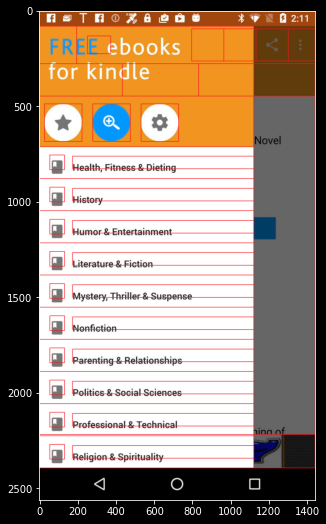

In [12]:
def draw_bndboxes(filename, return_img=False):
    test_image_file = screenshots_path / f"{filename}.jpg"

    image = cv2.imread(test_image_file.as_posix())
    image = cv2.resize(image, (1440, 2560))
    a_df = annotations_df[annotations_df["filename"] == f"{filename}.jpg"]
    for i, annotation in a_df.iterrows():
        pt1 = get_pt1(annotation)
        pt2 = get_pt2(annotation)
        x, y = pt1
        category = annotation.category
        cv2.rectangle(image, pt1, pt2, (250, 20, 30), 2)
    #         cv2.putText(image, category, (x, y-10), 0, 1, (250, 20, 30), 2, cv2.LINE_AA, False
    
    plt.imshow(image)


draw_bndboxes(9990, True)

In [13]:
annotations_df

,category,xmin,ymin,xmax,ymax,width,height,area,level,is_parent,text,filename,image_width,image_height
0,Text,14,86,1426,167,1412,81,114372,2,False,Santa Scanner,22161.jpg,1440,2392
1,Image,35,1849,385,2199,350,350,122500,2,False,-,22161.jpg,1440,2392
2,Image,1055,1849,1405,2199,350,350,122500,2,False,-,22161.jpg,1440,2392
3,Image,1125,1464,1405,1744,280,280,78400,2,False,-,22161.jpg,1440,2392
4,Image,385,1989,1055,2199,670,210,140700,2,False,-,22161.jpg,1440,2392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303419,Slider,215,2280,1316,2392,1101,112,123312,2,False,-,30576.jpg,1440,2560
1303420,Text,1316,2305,1405,2367,89,62,5518,2,False,0:09,30576.jpg,1440,2560
1303421,Text,70,154,1370,838,1300,684,889200,2,False,Pattern recorded!,25154.jpg,1440,2560
1303422,Text Button,140,2070,699,2210,559,140,78260,2,False,Cancel,25154.jpg,1440,2560
